In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

from graspologic.embed import AdjacencySpectralEmbed
from graspologic.simulations import sbm
from graspologic.plot import heatmap, pairplot

from sklearn.utils.extmath import svd_flip
from sklearn.decomposition._pca import _infer_dimension
from scipy import linalg

import warnings
warnings.filterwarnings('ignore')
np.random.seed(8889)
%matplotlib inline

# Simulation 1

Procedure of the experiment

https://www.sciencedirect.com/science/article/abs/pii/S0167947305002343

***
We have to note that these function all take in as input a Matrix do the PCA with 

1.&emsp; Create matrix $A =  X \Lambda X^{T}$ by generating eigenvalues with following distributions and corresponding unit norm eigenvectors 

2.&emsp; The two distributions are (a) $\lambda_1...\lambda_{50}$ ~ Uniform(1, 70), $\lambda_{51}...\lambda_{100}$ ~ Uniform(90, 160); Here we expect to see that screen plot elbow at 50. For distribution (b) $\lambda_1...\lambda_{80}$ ~ Uniform(1, 100), $\lambda_{81}...\lambda_{100}$ ~ Uniform(120, 160); Here we expect the elbow to be at 20. Eigenvectors are random orthogonal matrix, drawn from the O(N) Haar distribution (the only uniform distribution on O(N)).

3.&emsp; Generate 100 A matrices then take the median of the first elbow guess for ZG(2) and minka from the 100 trials. 


In [2]:
from scipy import linalg
from scipy.stats import ortho_group

l1 = set()
while len(l1) < 50: 
    l1.add(np.random.randint(1, 70))
l2 = set()
while len(l2) <50: 
    l2.add(np.random.randint(90, 160))

Lam = np.diag(list(l1) + list(l2))
x = ortho_group.rvs(100)
A = x @ Lam @ np.transpose(x)

In [3]:
from graspologic.embed import select_dimension
select_dimension(A, n_components = A.shape[1] - 1)

([50, 73], [91.0000000000001, 37.99999999999999])

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#Make a random array and then make it positive-definite
# true -- where we expect value to be 
# d1 -- ZG no hack elbow 1
# d2 -- ZG no hack elbow 2
# d3 -- minka 
# d4 -- ZG  hack elbow 1
# d5 -- ZG  hack elbow 2
def scree(A, true, d1, d2, d3, d4, d5):
    colors = sns.color_palette()
    U, S, V = np.linalg.svd(A) 
    eigvals = S**2 / np.sum(S**2) 
    fig = plt.figure(figsize=(8,5))
    sing_vals = np.arange(S.shape[0]) + 1
    plt.plot(sing_vals, eigvals, 'ro-', color = colors[4], linewidth=1)
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Eigenvalue')
    plt.axvline(true, label='true dim {}'.format(true), color=colors[3], linewidth = 7)
    plt.axvline(np.median(d1), label='Est dim {} from ZG 1 elbow'.format(np.median(d1)), color=colors[0], ls='--')
    plt.axvline(np.median(d2), label='Est dim {} from ZG 2 elbow'.format(np.median(d2)), color=colors[0], ls=':')
    plt.axvline(np.median(d3), label='Est dim {} from minka'.format(np.median(d3)), color=colors[1], ls='--')
    plt.axvline(np.median(d4), label='Est dim {} from ZG hack 1 elbow'.format(np.median(d4)), color= colors[2], ls='--')
    plt.axvline(np.median(d5), label='Est dim {} from ZG hack 2 elbow'.format(np.median(d5)), color=colors[2], ls=':')
    plt.legend(bbox_to_anchor=(.8, 1), loc='upper left',)

In [5]:
from sklearn.utils.extmath import svd_flip
from sklearn.decomposition._pca import _infer_dimension
from scipy import linalg

def minka(X):
    
    n_components = 'mle'
    n_samples = X.shape[0]
    U, S, Vt = linalg.svd(X, full_matrices=False)
    # flip eigenvectors' sign to enforce deterministic output
    U, Vt = svd_flip(U, Vt)

    components_ = Vt

    # Get variance explained by singular values
    explained_variance_ = (S ** 2) / (n_samples - 1)
    total_var = explained_variance_.sum()
    explained_variance_ratio_ = explained_variance_ / total_var
    singular_values_ = S.copy()  # Store the singular values.
    # Postprocess the number of components required
    if n_components == 'mle':
        #print(explained_variance_.shape[0])
        #print(n_samples)
        n_components = \
            _infer_dimension(explained_variance_, n_samples)
    return n_components

In [6]:
minka(A)

1

In [7]:
dims_minka = []
dims_ZG_1 = []
dims_ZG_2 = []
dims_ZG_h_1 = []
dims_ZG_h_2 = []
for i in range(100):
    l1 = set()
    while len(l1) < 50: 
        l1.add(np.random.randint(1, 70))
    l2 = set()
    while len(l2) <50: 
        l2.add(np.random.randint(90, 160))
    Lam = np.diag(list(l1) + list(l2))
    x = ortho_group.rvs(100)
    A = x @ Lam @ np.transpose(x)
    d = select_dimension(A, n_components = A.shape[1] - 1)
    d_h = select_dimension(A)
    # due to the function not always returning two element list we only append the first
    dims_ZG_1.append(d[0][0])
    dims_ZG_h_1.append(d_h[0][0])
    if len(d[0]) > 1:
        dims_ZG_2.append(d[0][1])
    else:
        dims_ZG_2.append(0)
    if len(d_h[0]) > 1:
        dims_ZG_h_2.append(d_h[0][1])
    else:
        dims_ZG_h_2.append(0)
    
    dims_minka.append(minka(A))
dims_ZG_1 = np.asarray(dims_ZG_1)
dims_minka = np.asarray(dims_minka)
dims_ZG_2 = np.asarray(dims_ZG_2)
dims_ZG_h_1 = np.asarray(dims_ZG_h_1)
dims_ZG_h_2 = np.asarray(dims_ZG_h_2)

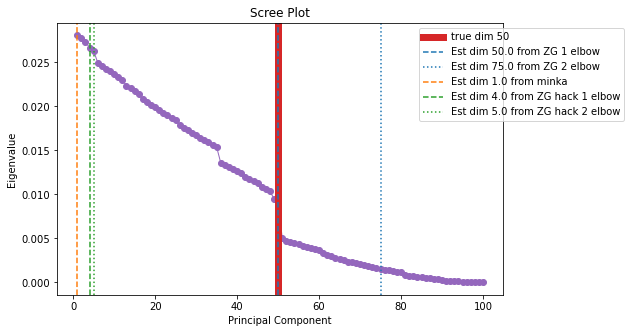

In [8]:
scree(A, 50, dims_ZG_1, dims_ZG_2, dims_minka, dims_ZG_h_1, dims_ZG_h_2)

### now with distribution b for eigenvals

In [9]:
dims_minka = []
dims_ZG_1 = []
dims_ZG_2 = []
dims_ZG_h_1 = []
dims_ZG_h_2 = []
for i in range(10):
    l1 = set()
    while len(l1) < 80: 
        l1.add(np.random.randint(1, 100))
    l2 = set()
    while len(l2) <20: 
        l2.add(np.random.randint(120, 160))
    Lam = np.diag(list(l1) + list(l2))
    x = ortho_group.rvs(100)
    A = x @ Lam @ np.transpose(x)
    d = select_dimension(A, n_components = A.shape[1] - 1)
    # due to the function not always returning two element list we only append the first 
    d_h = select_dimension(A)
    # due to the function not always returning two element list we only append the first
    dims_ZG_1.append(d[0][0])
    dims_ZG_h_1.append(d_h[0][0])
    if len(d[0]) > 1:
        dims_ZG_2.append(d[0][1])
    else:
        dims_ZG_2.append(0)
    if len(d_h[0]) > 1:
        dims_ZG_h_2.append(d_h[0][1])
    else:
        dims_ZG_h_2.append(0)
    
    dims_minka.append(minka(A))
dims_ZG_1 = np.asarray(dims_ZG_1)
dims_minka = np.asarray(dims_minka)
dims_ZG_2 = np.asarray(dims_ZG_2)
dims_ZG_h_1 = np.asarray(dims_ZG_h_1)
dims_ZG_h_2 = np.asarray(dims_ZG_h_2)


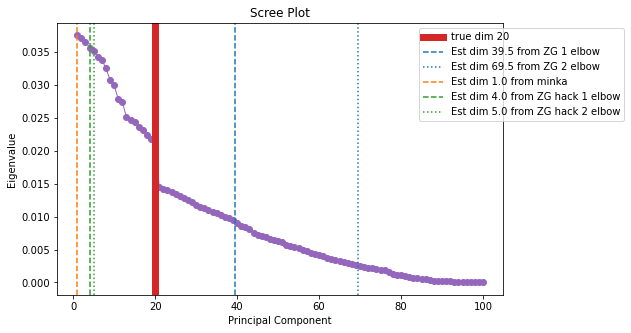

In [10]:
scree(A, 20, dims_ZG_1, dims_ZG_2, dims_minka, dims_ZG_h_1, dims_ZG_h_2)


# Notes and conlcusion: Though this experiment was taken from ZG paper, it does not perform very well. It does perfrom better than minka howevever. This could be due to the fact that this is not low rank. I propose another simulation simialr to this one but instead it is low rank with an elbow at 3 or four. 

# Simulation 1.1

Procedure of the experiment

Automatic dimensionality selection from the scree plot via the use of profile likelihood
Mu Zhu∗, Ali Ghodsi

***
We have to note that these function all take in as input a Matrix do the PCA with 

1.&emsp; Create matrix $A =  X \Lambda X^{T}$ by generating eigenvalues with following distributions and corresponding unit norm eigenvectors 

2.&emsp; The two distributions are (a) $\lambda_1...\lambda_{5}$ ~ Uniform(1, 20), $\lambda_{6}...\lambda_{10}$ ~ Uniform(40, 60); Here we expect to see that screen plot elbow at 5. For distribution. Eigenvectors are random orthogonal matrix, drawn from the O(N) Haar distribution (the only uniform distribution on O(N)).

3.&emsp; Generate 100 A matrices then take the median of the first elbow guess for ZG(2) and minka from the 100 trials. 

In [11]:
dims_minka = []
dims_ZG_1 = []
dims_ZG_2 = []
dims_ZG_h_1 = []
dims_ZG_h_2 = []
for i in range(100):
    l1 = set()
    while len(l1) < 5: 
        l1.add(np.random.randint(1, 20))
    l2 = set()
    while len(l2) <5: 
        l2.add(np.random.randint(40, 60))
    Lam = np.diag(list(l1) + list(l2))
    x = ortho_group.rvs(10)
    A = x @ Lam @ np.transpose(x)
    d = select_dimension(A, n_components = A.shape[1] - 1)
    # due to the function not always returning two element list we only append the first 
    d_h = select_dimension(A)
    # due to the function not always returning two element list we only append the first
    dims_ZG_1.append(d[0][0])
    dims_ZG_h_1.append(d_h[0][0])
    if len(d[0]) > 1:
        dims_ZG_2.append(d[0][1])
    else:
        dims_ZG_2.append(0)
    if len(d_h[0]) > 1:
        dims_ZG_h_2.append(d_h[0][1])
    else:
        dims_ZG_h_2.append(0)
    
    dims_minka.append(minka(A))
dims_ZG_1 = np.asarray(dims_ZG_1)
dims_minka = np.asarray(dims_minka)
dims_ZG_2 = np.asarray(dims_ZG_2)
dims_ZG_h_1 = np.asarray(dims_ZG_h_1)
dims_ZG_h_2 = np.asarray(dims_ZG_h_2)



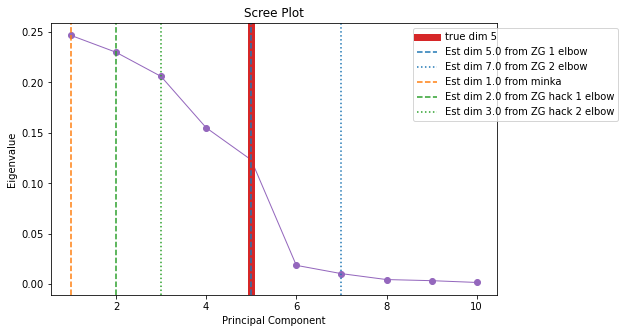

In [12]:
scree(A, 5, dims_ZG_1, dims_ZG_2, dims_minka, dims_ZG_h_1, dims_ZG_h_2)

# Simulation 2

Procedure of the experiment
Automatic dimensionality selection from the scree plot via the use of profile likelihood
Mu Zhu∗, Ali Ghodsi

***

This deals with linear subspaces

1.&emsp; Generate 5 basis vectors $B = b_1, ..., b_5$ that lie in $R^{50}$ with Standard normal Gaussian. 

2.&emsp; Randomly generate 200 random data points in $R^{50}$ and then add noise. In effect generate 10000 from standard Gaussian and arrange them in Z = 50x200 matrix. 

3.&emsp; Generate E a 50x200 . $$ E = \begin{bmatrix} normal(\mu, \sigma) & \dots \\ \vdots & \ddots & \\ \end{bmatrix}$$ such that $\mu = 0, \sigma = .75$

4.&emsp; then we do PCA on $A = B(B^T B)^{-1}B^T Z + E $. Note that here we can test how resistant minka and ZG(2) are to noise by changin $\mu, \sigma$.

5.&emsp; when applying dimension estimation we should see after running 100 trials and taking median from both minka and ZG(2) are 5




In [13]:
a = np.random.normal(0, 1, (50, 5))
B, _ = np.linalg.qr(a)
Z = np.random.random(size=(50, 200))
E = np.random.normal(0, .75, (50, 200))
A = (B @ np.linalg.inv(np.transpose(B) @ B) @ np.transpose(B) @ Z) + E
minka(A)

45

In [14]:
A.shape

(50, 200)

In [15]:
select_dimension(A, n_components = A.shape[0]-1)

([23, 36], [10.77408310064057, 8.331142730449406])

In [16]:
dims_minka = []
dims_ZG_1 = []
dims_ZG_2 = []
dims_ZG_h_1 = []
dims_ZG_h_2 = []
for i in range(100):
    a = np.random.normal(0, 1, (50, 5))
    B, _ = np.linalg.qr(a)
    Z = np.random.normal(size=(50, 200))
    E = np.random.normal(0, .75, (50, 200))
    A = (B @ np.linalg.inv(np.transpose(B) @ B) @ np.transpose(B) @ Z) + E
    d = select_dimension(A, n_components = A.shape[0]-1)
    # due to the function not always returning two element list we only append the first 
    d_h = select_dimension(A)
    # due to the function not always returning two element list we only append the first
    dims_ZG_1.append(d[0][0])
    dims_ZG_h_1.append(d_h[0][0])
    if len(d[0]) > 1:
        dims_ZG_2.append(d[0][1])
    else:
        dims_ZG_2.append(0)
    if len(d_h[0]) > 1:
        dims_ZG_h_2.append(d_h[0][1])
    else:
        dims_ZG_h_2.append(0)
    
    dims_minka.append(minka(A))
dims_ZG_1 = np.asarray(dims_ZG_1)
dims_minka = np.asarray(dims_minka)
dims_ZG_2 = np.asarray(dims_ZG_2)
dims_ZG_h_1 = np.asarray(dims_ZG_h_1)
dims_ZG_h_2 = np.asarray(dims_ZG_h_2)


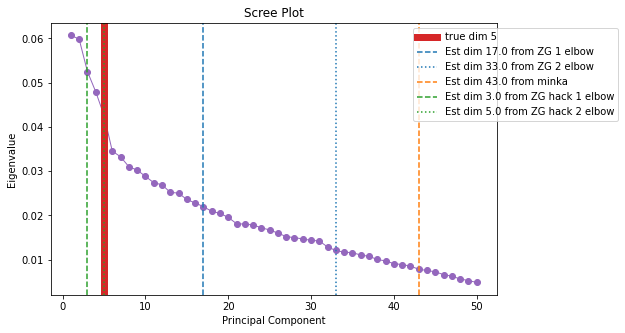

In [17]:
scree(A, 5, dims_ZG_1, dims_ZG_2, dims_minka, dims_ZG_h_1, dims_ZG_h_2)

# Robustness to noise

Procedure of the experiment
Automatic dimensionality selection from the scree plot via the use of profile likelihood
Mu Zhu∗, Ali Ghodsi

***

1.&emsp; Generate 5 basis vectors $B = b_1, ..., b_5$ that lie in $R^{50}$ with Standard normal Gaussian. 

2.&emsp; Randomly generate 200 random data points in $R^{50}$ and then add noise. In effect generate 10000 from standard Gaussian and arrange them in Z = 50x200 matrix. 

3.&emsp; Generate E a 50x200 . $$ E = \begin{bmatrix} normal(\mu, \sigma) & \dots \\ \vdots & \ddots & \\ \end{bmatrix}$$ such that $\mu = 0, \sigma = .75$

4.&emsp; then we do dimension selection on $A = B(B^T B)^{-1}B^T Z + E $. 

4.1.&emsp; We Vary the distribution that governs E by first having an E with distrubtion $\mu = 0, \sigma = .75$, then $\mu = 0, \sigma = 1.5$, $\mu = 0, \sigma = 2$, $\mu = .5, \sigma = .75$, $\mu = -.5, \sigma = .75$

5.&emsp; when applying dimension estimation we should see after running 100 trials and taking median from both minka and ZG(2) are 5

In [18]:
dims_minka = []
dims_ZG_1 = []
dims_ZG_2 = []
dims_ZG_h_1 = []
dims_ZG_h_2 = []
normal_dist = [[0, .75], [0, 1.5], [0, 2], [.5, .75], [-.5, .75] ]
for j in range(len(normal_dist)):
    for i in range(100):
        a = np.random.normal(0, 1, (50, 5))
        B, _ = np.linalg.qr(a)
        Z = np.random.normal(size=(50, 200))
        E = np.random.normal(normal_dist[j][0], normal_dist[j][1], (50, 200))
        A = (B @ np.linalg.inv(np.transpose(B) @ B) @ np.transpose(B) @ Z) + E
        d = select_dimension(A, n_components = A.shape[0]-1)
        # due to the function not always returning two element list we only append the first 
        d_h = select_dimension(A)
        # due to the function not always returning two element list we only append the first
        dims_ZG_1.append(d[0][0])
        dims_ZG_h_1.append(d_h[0][0])
        if len(d[0]) > 1:
            dims_ZG_2.append(d[0][1])
        else:
            dims_ZG_2.append(0)
        if len(d_h[0]) > 1:
            dims_ZG_h_2.append(d_h[0][1])
        else:
            dims_ZG_h_2.append(0)

        dims_minka.append(minka(A))
    
#dims_ZG_1 = np.asarray(dims_ZG_1)
#dims_minka = np.asarray(dims_minka)
#dims_ZG_2 = np.asarray(dims_ZG_2)

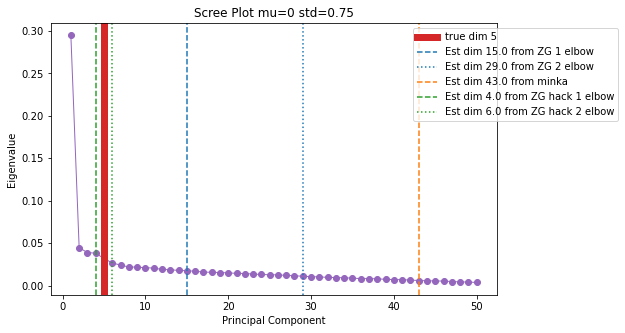

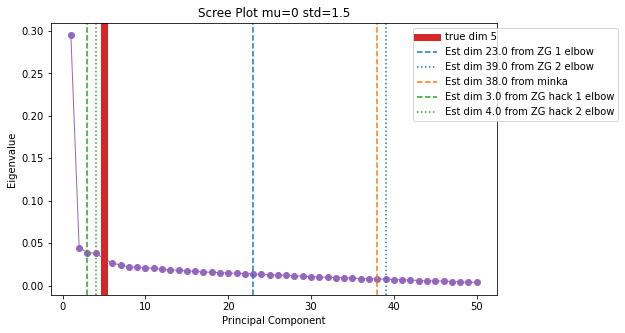

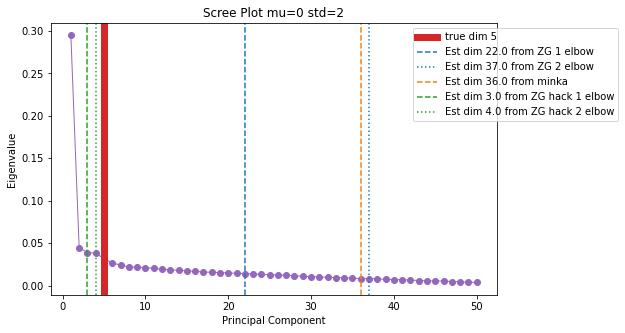

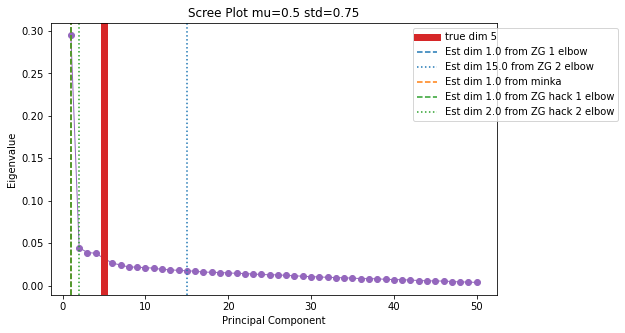

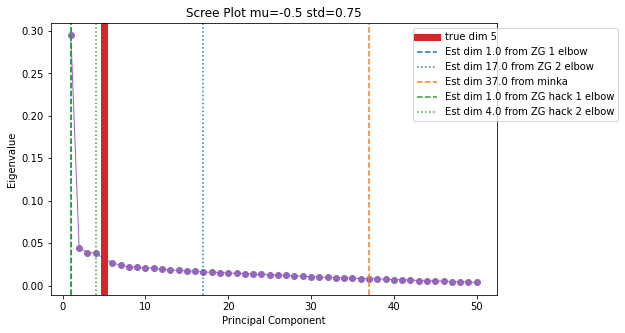

In [19]:
for i in range(len(normal_dist)):
    scree(A, 5, dims_ZG_1[i*100:(i*100) + 1], dims_ZG_2[i*100:(i*100) + 1], dims_minka[i*100:(i*100) + 1], 
          dims_ZG_h_1[i*100:(i*100) + 1], dims_ZG_h_2[i*100:(i*100) + 1])
    plt.title('Scree Plot mu=' + str(normal_dist[i][0]) + " std=" + str(normal_dist[i][1]))
    
    

## Nonlinear? Real data? 

like a swiss roll or using MNIST? 

# Simulation 3

Procedure of the experiment


https://papers.nips.cc/paper/1853-automatic-choice-of-dimensionality-for-pca.pdf

***

The first experiment tests the data-rich case where N > > d




1.&emsp; Using multivate Gaussian make Cov matrix with [10, 8, 6, 4, 2, 1, 1, 1, 1, 1] along its diagonal, 0 elsewhere, hence covariance matrix has evals of the above list. Then make means 0 for all dimensions. Create 100 10 dimensional vectors  with this using Gausian multivariate distrubtion with the mentioned means and covariance matrix.  

2.&emsp; Create 100 A matrices that follow the above criteria, run dimension selection on these, take median for estimate


In [20]:
from scipy import linalg
from scipy.stats import ortho_group

In [21]:
Cov = np.diag([10, 8, 6, 4, 2, 1, 1, 1, 1, 1])
means = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
dims_minka = []
dims_ZG_1 = []
dims_ZG_2 = []
dims_ZG_h_1 = []
dims_ZG_h_2 = []
for i in range(100):
    A = np.random.multivariate_normal(means, Cov, 100)
    d = select_dimension(A, n_components = A.shape[1]-1)
    # due to the function not always returning two element list we only append the first 
    d_h = select_dimension(A)
    # due to the function not always returning two element list we only append the first
    dims_ZG_1.append(d[0][0])
    dims_ZG_h_1.append(d_h[0][0])
    if len(d[0]) > 1:
        dims_ZG_2.append(d[0][1])
    else:
        dims_ZG_2.append(0)
    if len(d_h[0]) > 1:
        dims_ZG_h_2.append(d_h[0][1])
    else:
        dims_ZG_h_2.append(0)
    
    dims_minka.append(minka(A))
dims_ZG_1 = np.asarray(dims_ZG_1)
dims_minka = np.asarray(dims_minka)
dims_ZG_2 = np.asarray(dims_ZG_2)
dims_ZG_h_1 = np.asarray(dims_ZG_h_1)
dims_ZG_h_2 = np.asarray(dims_ZG_h_2)


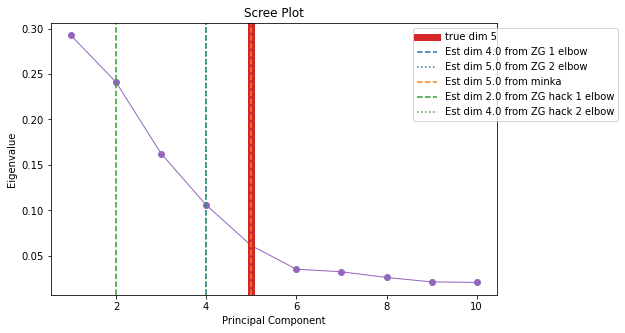

In [22]:
scree(A, 5, dims_ZG_1, dims_ZG_2, dims_minka, dims_ZG_h_1, dims_ZG_h_2)

# Simulation 3.1

Procedure of the experiment

https://papers.nips.cc/paper/1853-automatic-choice-of-dimensionality-for-pca.pdf

***

The second experiment tests the case of sparse data and low noise:

1.&emsp; Using multivate Gaussian make Cov matrix with [10, 8, 6, 4, 2, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1] along its diagonal, 0 elsewhere, hence covariance matrix has evals of the above list. Then make means 0 for all dimensions. Create 15 10 dimensional vectors  with this using Gausian multivariate distrubtion with the mentioned means and covariance matrix. 

2.&emsp; Create 100 A matrices that follow the above criteria, run dimension selection on these, take median for estimate


In [23]:
Cov = np.diag([10, 8, 6, 4, 2] + [.1]*10)
means = [0] *len(Cov)
dims_minka = []
dims_ZG_1 = []
dims_ZG_2 = []
dims_ZG_h_1 = []
dims_ZG_h_2 = []
for i in range(100):
    A = np.random.multivariate_normal(means, Cov, 15)
    d = select_dimension(A, n_components = A.shape[1]-1)
    # due to the function not always returning two element list we only append the first 
    d_h = select_dimension(A)
    # due to the function not always returning two element list we only append the first
    dims_ZG_1.append(d[0][0])
    dims_ZG_h_1.append(d_h[0][0])
    if len(d[0]) > 1:
        dims_ZG_2.append(d[0][1])
    else:
        dims_ZG_2.append(0)
    if len(d_h[0]) > 1:
        dims_ZG_h_2.append(d_h[0][1])
    else:
        dims_ZG_h_2.append(0)
    
    dims_minka.append(minka(A))
dims_ZG_1 = np.asarray(dims_ZG_1)
dims_minka = np.asarray(dims_minka)
dims_ZG_2 = np.asarray(dims_ZG_2)
dims_ZG_h_1 = np.asarray(dims_ZG_h_1)
dims_ZG_h_2 = np.asarray(dims_ZG_h_2)



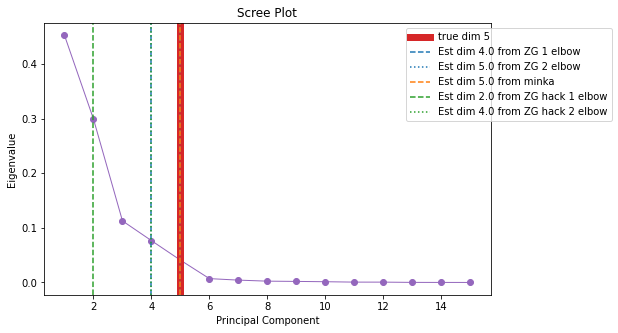

In [24]:
scree(A, 5, dims_ZG_1, dims_ZG_2, dims_minka, dims_ZG_h_1, dims_ZG_h_2)

# Simulation 4
Josse https://www.sciencedirect.com/science/article/pii/S0167947311004099 

***

The second experiment tests the case of sparse data and low noise:

1.&emsp; Using multivate Gaussian make Cov matrix with specfications which can be read from Josse paper Fig 5, first row for the covariance matrix. Sample 1000 times with a multivariate norm with this covariance and mean = 0. 

2.&emsp; Create 100 A matrices that follow the above criteria, run dimension selection on these, take median for estimate

In [25]:
def fill_block(s, e, on_diag, off_diag_in, arr):
    for i in range(s, e):
        for j in range(s, e):
            if j != i:
                arr[i, j] = off_diag_in
            else:
                arr[i, j] = on_diag

# params = [size, comp_1, comp_2_ind, comp_3_ind, off_comp, c1_off, c1_on, c2_off, c2_on,c3_off, c3_on ]
def make_cov(params):
    arr = np.reshape(np.asarray([params[4]]*(params[0]**2)), (params[0],params[0]))
    fill_block(params[1], params[2], params[6], params[5], arr)
    fill_block(params[2], params[3], params[8], params[7], arr)
    fill_block(params[3], params[0], params[10], params[9], arr)
    return arr

In [26]:
params_9 = [
    [9, 0, 4, 7, 0, .8, 1, .8, 1,.8, 1],
    [9, 0, 4, 7, .3, .8, 1, .8, 1,.8, 1],
    [9, 0, 4, 7, .5, .8, 1, .8, 1,.8, 1],
    [9, 0, 4, 7, 0, .5, 1, .5, 1,.5, 1],
    [9, 0, 4, 7, .3, .5, 1, .5, 1,.5, 1],
    [9, 0, 4, 7, 0, .3, 1, .3, 1,.3, 1],
    [9, 0, 4, 7, 0, .8, 1, .5, 1,.3, 1],
    [9, 0, 4, 7, .2, .8, 1, .5, 1,.3, 1],
    [9, 0, 3, 6, 0, .8, 1, .5, 1,.3, 1],
    [9, 0, 3, 6, 0, .8, 1, .5, 1, 0, 1],
    [9, 0, 3, 6, 0, .5, 1, .3, 1, 0, 1],
    [9, 0, 3, 6, 0, .8, 1, 0, 1, 0, 1],
    [9, 0, 3, 6, 0, .5, 1, 0, 1, 0, 1],
    [9, 0, 3, 6, 0, .3, 1, 0, 1, 0, 1],
    [9, 0, 3, 6, .8, .8, 1, .8, 1, .8, 1],
    [9, 0, 3, 6, .8, .8, 1, .8, 1, .8, 1],
    [9, 0, 3, 6, .5, .5, 1, .5, 1, .5, 1],
    [9, 0, 3, 6, .3, .3, 1, .3, 1, .3, 1],
]

In [27]:
dims_minka = []
dims_ZG_1 = []
dims_ZG_2 = []
dims_ZG_h_1 = []
dims_ZG_h_2 = []
means = [0] *9
A_t = []
for k in range(len(params_9)):
    for i in range(100):
        cov = make_cov(params_9[k])
        A = np.random.multivariate_normal(means, np.asarray(cov), 1000)
        d = select_dimension(A, n_components = A.shape[1]-1)
        # due to the function not always returning two element list we only append the first 
        d_h = select_dimension(A)
        # due to the function not always returning two element list we only append the first
        dims_ZG_1.append(d[0][0])
        dims_ZG_h_1.append(d_h[0][0])
        if len(d[0]) > 1:
            dims_ZG_2.append(d[0][1])
        else:
            dims_ZG_2.append(0)
        if len(d_h[0]) > 1:
            dims_ZG_h_2.append(d_h[0][1])
        else:
            dims_ZG_h_2.append(0)

        dims_minka.append(minka(A))
    A_t.append(A)
    


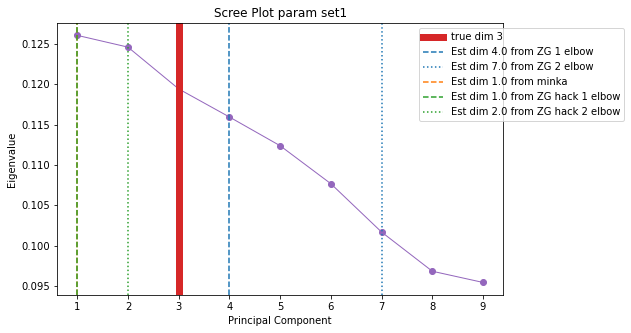

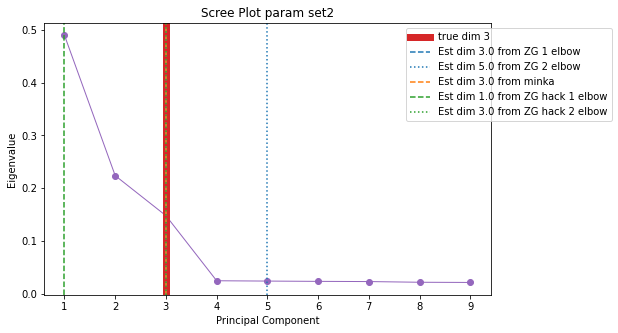

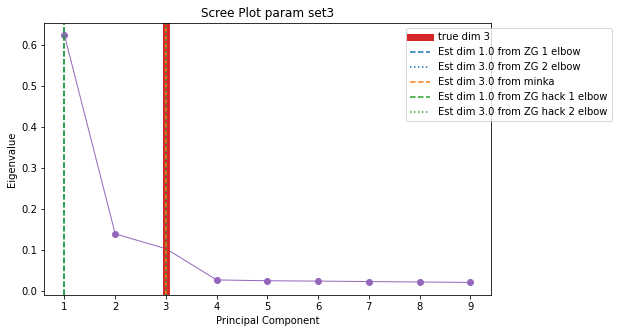

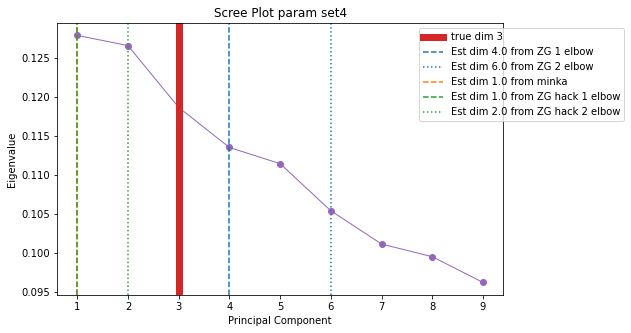

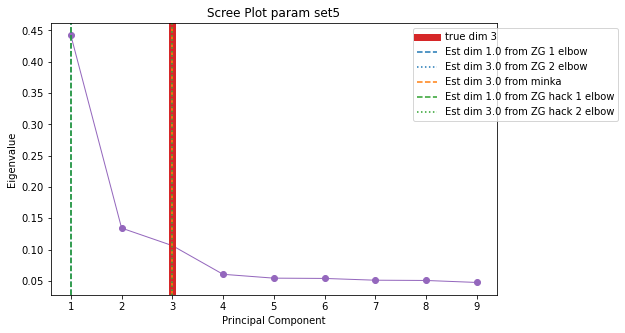

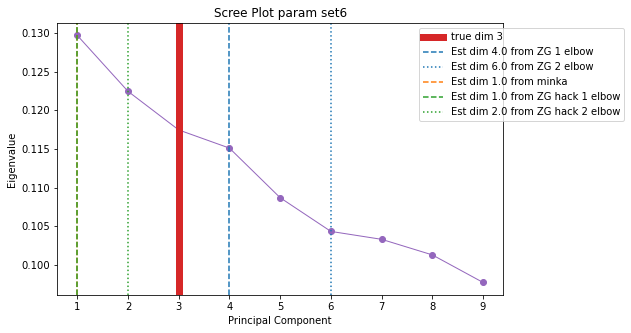

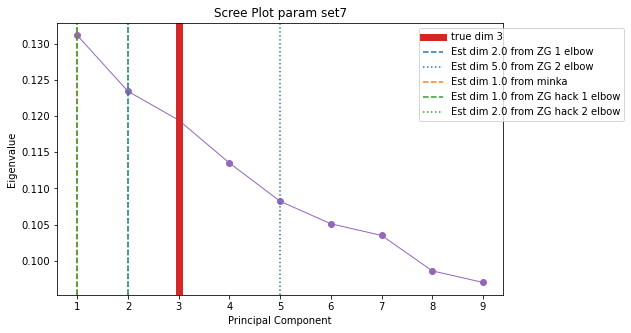

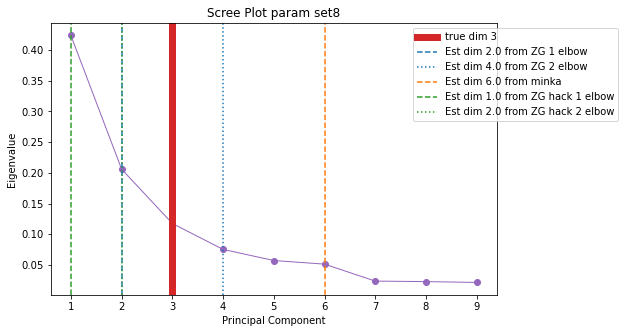

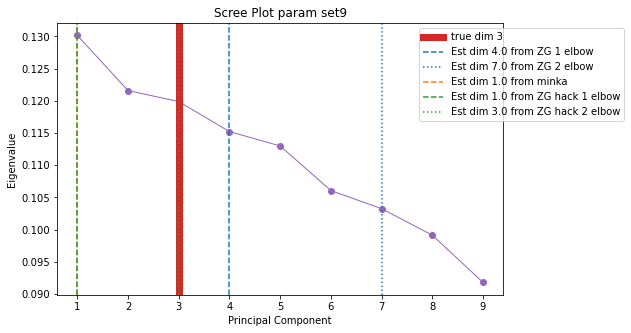

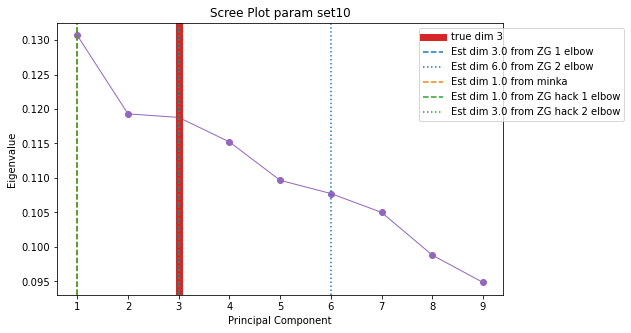

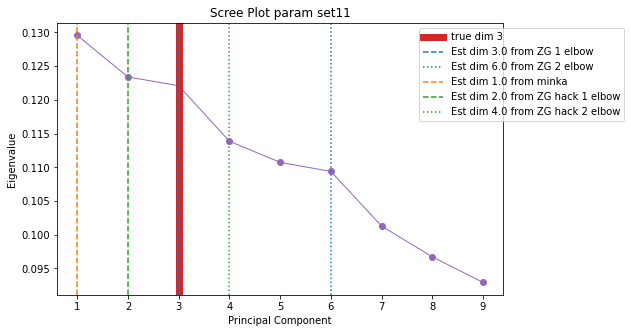

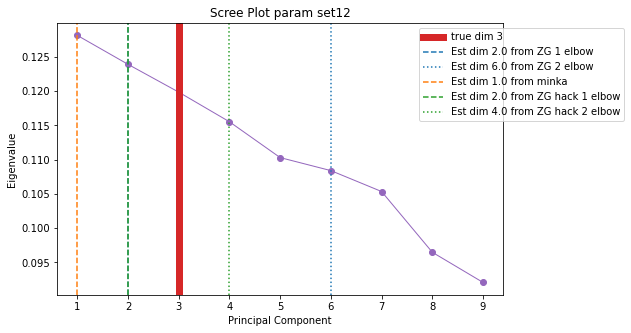

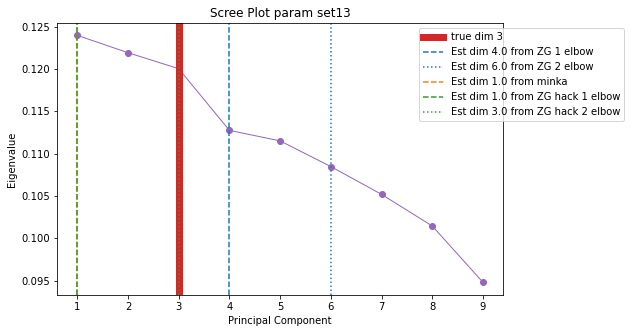

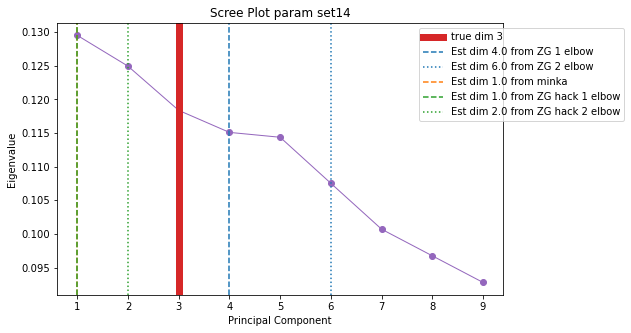

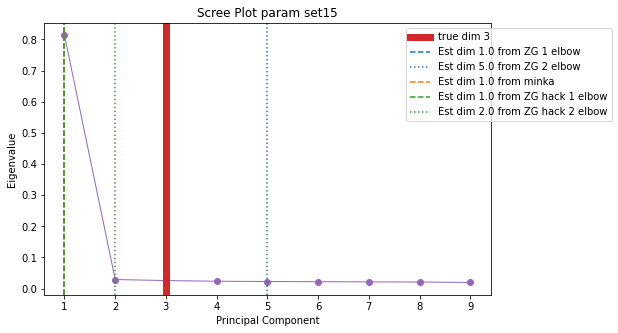

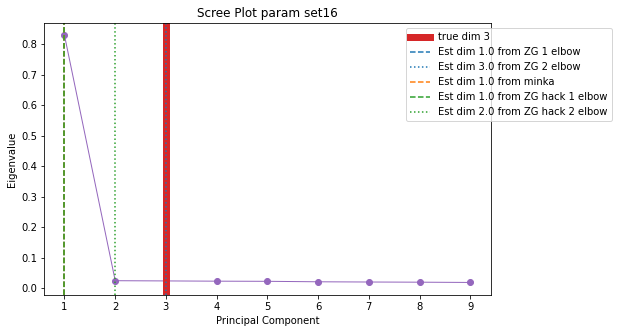

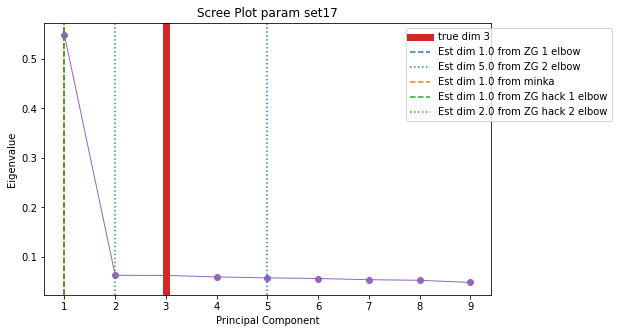

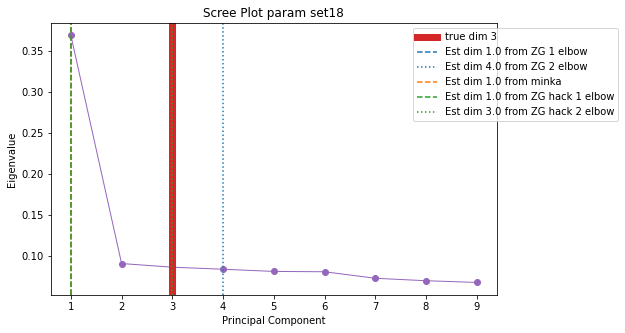

In [28]:
for i in range(len(params_9)):
    scree(A_t[i], 3, dims_ZG_1[i*100:(i*100) + 1], dims_ZG_2[i*100:(i*100) + 1], dims_minka[i*100:(i*100) + 1], 
          dims_ZG_h_1[i*100:(i*100) + 1], dims_ZG_h_2[i*100:(i*100) + 1])
    plt.title('Scree Plot param set' + str(i + 1))

In [29]:
params_18 = [
    [18, 0, 8, 14, 0, .8, 1, .8, 1,.8, 1],
    [18, 0, 8, 14, .3, .8, 1, .8, 1,.8, 1],
    [18, 0, 8, 14, .5, .8, 1, .8, 1,.8, 1],
    [18, 0, 8, 14, 0, .5, 1, .5, 1,.5, 1],
    [18, 0, 8, 14, .3, .5, 1, .5, 1,.5, 1],
    [18, 0, 8, 14, 0, .3, 1, .3, 1,.3, 1],
    [18, 0, 8, 14, 0, .8, 1, .5, 1,.3, 1],
    [18, 0, 8, 14, .2, .8, 1, .5, 1,.3, 1],
    [18, 0, 6, 12, 0, .8, 1, .5, 1,.3, 1],
    [18, 0, 6, 12, 0, .8, 1, .5, 1, 0, 1],
    [18, 0, 6, 12, 0, .5, 1, .3, 1, 0, 1],
    [18, 0, 6, 12, 0, .8, 1, 0, 1, 0, 1],
    [18, 0, 6, 12, 0, .5, 1, 0, 1, 0, 1],
    [18, 0, 6, 12, 0, .3, 1, 0, 1, 0, 1],
    [18, 0, 6, 12, .8, .8, 1, .8, 1, .8, 1],
    [18, 0, 6, 12, .8, .8, 1, .8, 1, .8, 1],
    [18, 0, 6, 12, .5, .5, 1, .5, 1, .5, 1],
    [18, 0, 6, 12, .3, .3, 1, .3, 1, .3, 1],
]

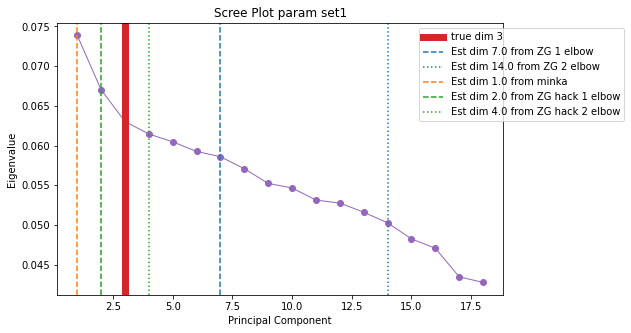

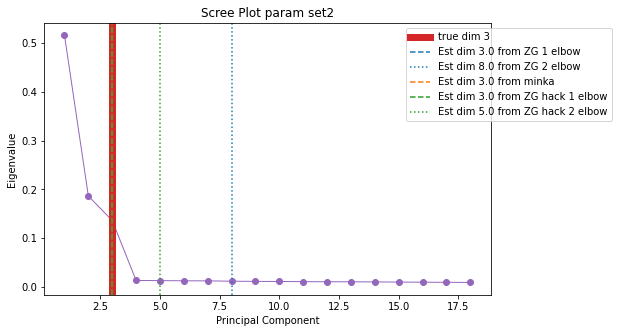

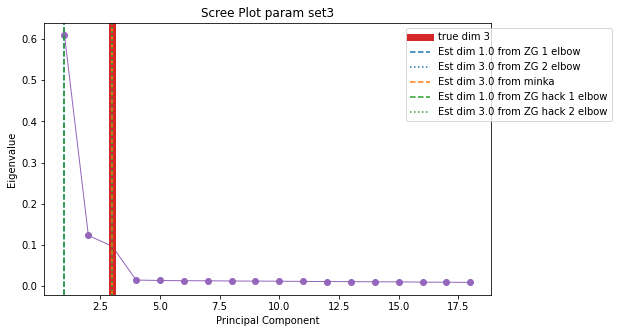

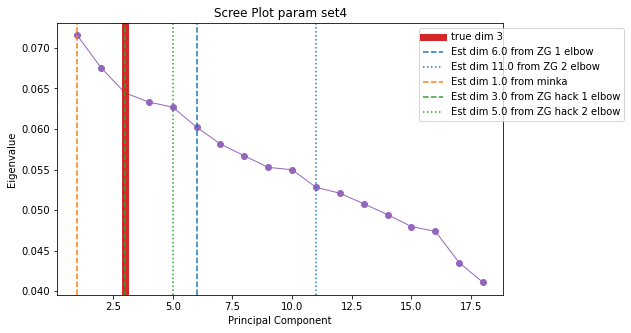

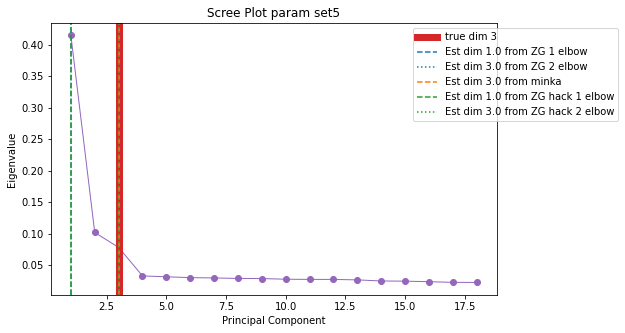

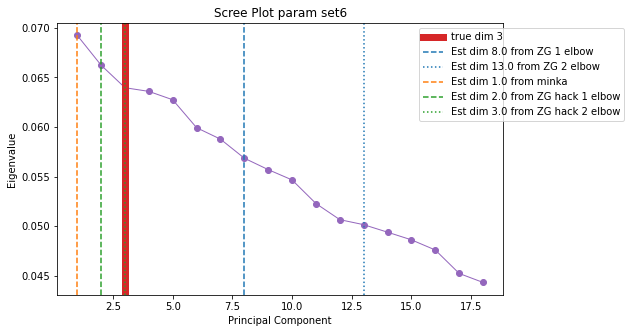

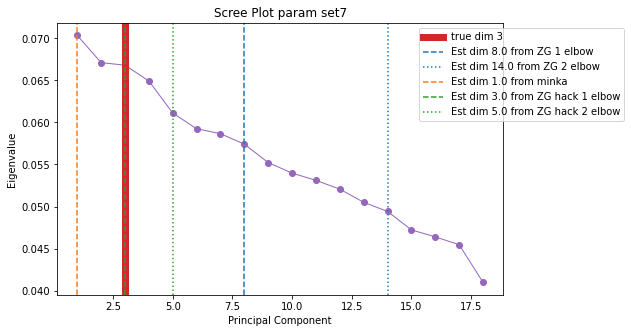

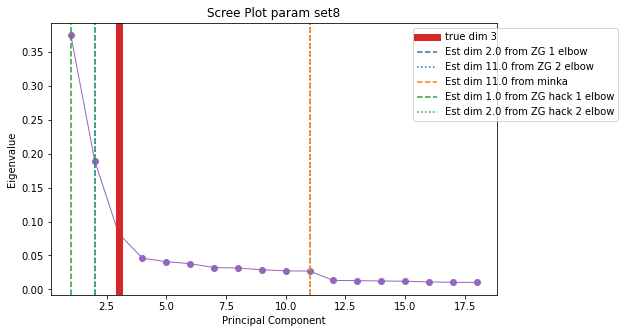

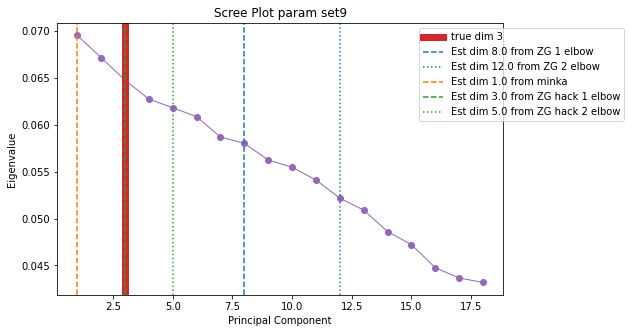

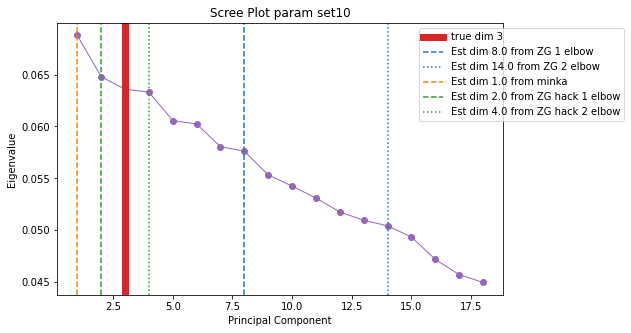

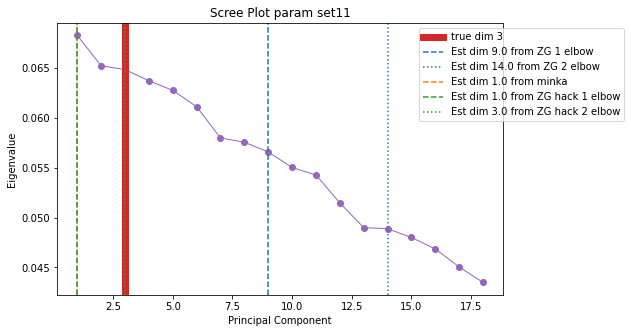

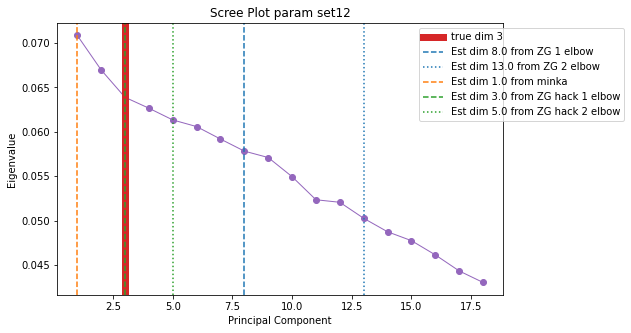

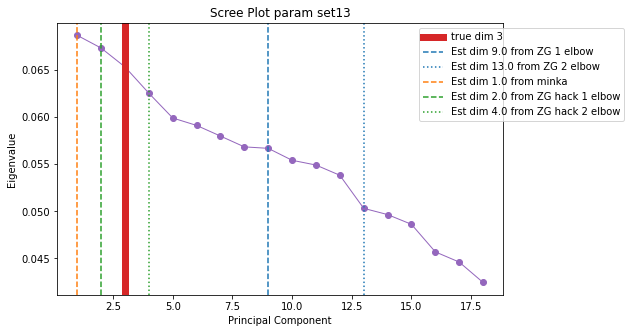

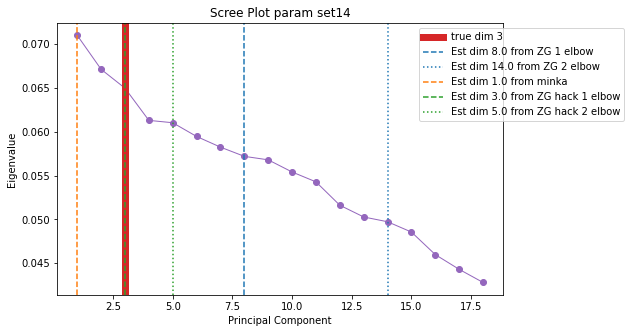

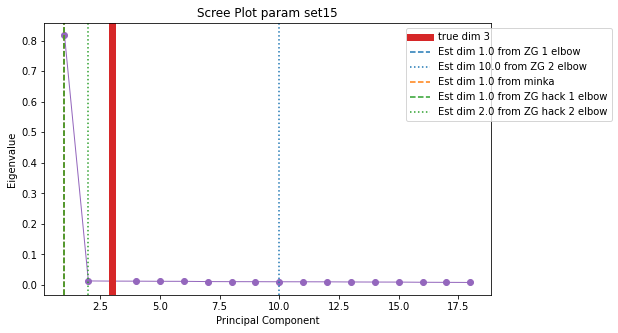

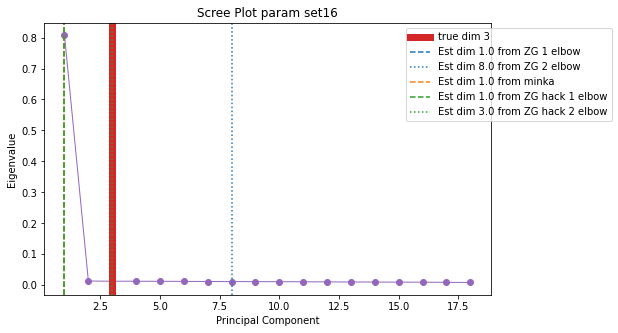

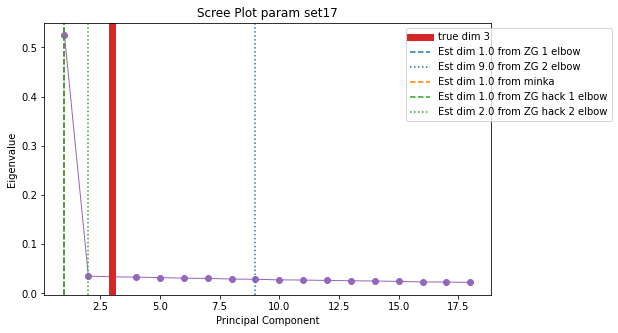

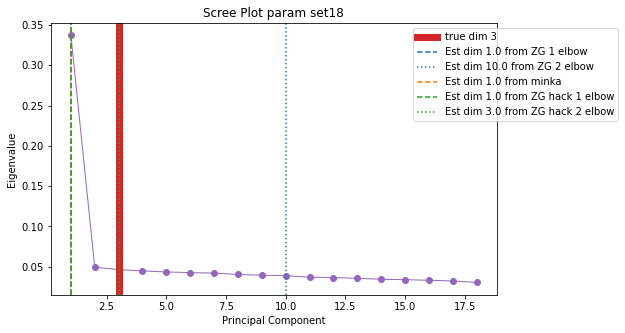

In [30]:
dims_minka = []
dims_ZG_1 = []
dims_ZG_2 = []
dims_ZG_h_1 = []
dims_ZG_h_2 = []
means = [0] *18
A_t = []
for k in range(len(params_18)):
    for i in range(100):
        cov = make_cov(params_18[k])
        A = np.random.multivariate_normal(means, np.asarray(cov), 1000)
        d = select_dimension(A, n_components = A.shape[1]-1)
        # due to the function not always returning two element list we only append the first 
        d_h = select_dimension(A)
        # due to the function not always returning two element list we only append the first
        dims_ZG_1.append(d[0][0])
        dims_ZG_h_1.append(d_h[0][0])
        if len(d[0]) > 1:
            dims_ZG_2.append(d[0][1])
        else:
            dims_ZG_2.append(0)
        if len(d_h[0]) > 1:
            dims_ZG_h_2.append(d_h[0][1])
        else:
            dims_ZG_h_2.append(0)

        dims_minka.append(minka(A))
    A_t.append(A)
    
for i in range(len(params_18)):
    scree(A_t[i], 3, dims_ZG_1[i*100:(i*100) + 1], dims_ZG_2[i*100:(i*100) + 1], dims_minka[i*100:(i*100) + 1], 
          dims_ZG_h_1[i*100:(i*100) + 1], dims_ZG_h_2[i*100:(i*100) + 1])
    plt.title('Scree Plot param set' + str(i + 1))

# Simulation 5
simulation matrices from 
https://github.com/idc9/ya_pca

In [31]:
from ya_pca.linalg_utils import svd_wrapper
from ya_pca.toy_data import perry_sim_dist, rand_factor_model
rank_true = 5
X, out = rand_factor_model(n_samples=80, n_features=50, rank=rank_true, noise_std=1,
                           m=1.5, random_state=213)

X, out = perry_sim_dist(strong=False, sparse=True, noise='white', random_state=5)



# SCREE COMPARISON 
simulations and minka and ZG functions not wrong --> the way i am displaying may not be the best

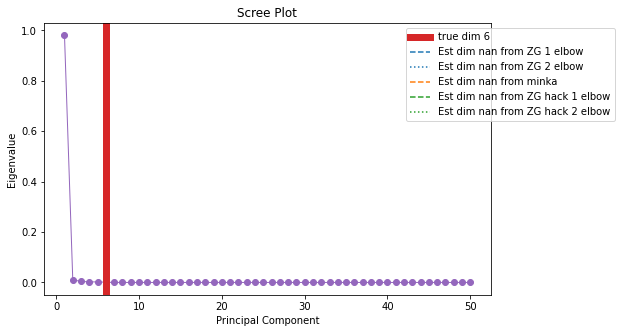

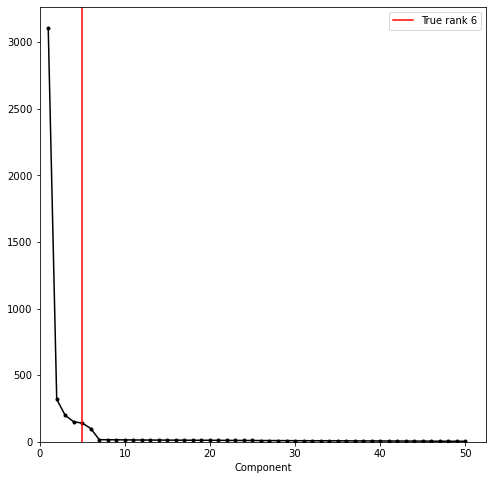

In [32]:
scree(X, 6, [],[],[],[],[])
from ya_pca.viz import scree_plot
n, d = X.shape

U, svals, V = svd_wrapper(X)

plt.figure(figsize=(8, 8))
scree_plot(svals, color='black')
plt.ylim(0)
plt.axvline(rank_true, label='True rank {}'.format(6), color='red')
plt.legend()

# 5.1 
https://github.com/idc9/ya_pca/blob/77f633643e9b9e092fe6f62266e21129393d08f7/ya_pca/toy_data.py#L11 

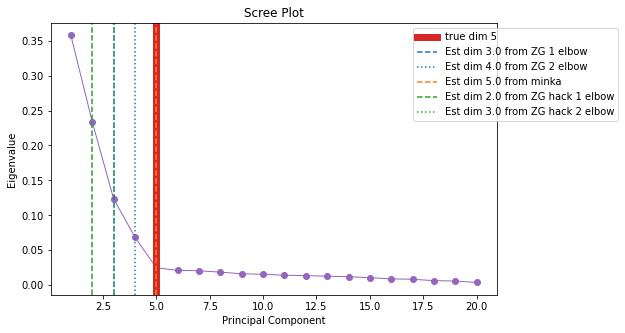

In [33]:
dims_minka = []
dims_ZG_1 = []
dims_ZG_2 = []
dims_ZG_h_1 = []
dims_ZG_h_2 = []
for i in range(100):
    A, out = rand_factor_model(n_samples=100, n_features=20, rank=5, m=1.5, noise_std=1.0, random_state=None)
    d = select_dimension(A, n_components = A.shape[1]-1)
    # due to the function not always returning two element list we only append the first 
    d_h = select_dimension(A)
    # due to the function not always returning two element list we only append the first
    dims_ZG_1.append(d[0][0])
    dims_ZG_h_1.append(d_h[0][0])
    if len(d[0]) > 1:
        dims_ZG_2.append(d[0][1])
    else:
        dims_ZG_2.append(0)
    if len(d_h[0]) > 1:
        dims_ZG_h_2.append(d_h[0][1])
    else:
        dims_ZG_h_2.append(0)
    
    dims_minka.append(minka(A))
dims_ZG_1 = np.asarray(dims_ZG_1)
dims_minka = np.asarray(dims_minka)
dims_ZG_2 = np.asarray(dims_ZG_2)
dims_ZG_h_1 = np.asarray(dims_ZG_h_1)
dims_ZG_h_2 = np.asarray(dims_ZG_h_2)
scree(A, 5, dims_ZG_1, dims_ZG_2, dims_minka, dims_ZG_h_1, dims_ZG_h_2)

## simulation 5.2
using perry_sim_dist https://github.com/idc9/ya_pca/blob/77f633643e9b9e092fe6f62266e21129393d08f7/ya_pca/toy_data.py#L109

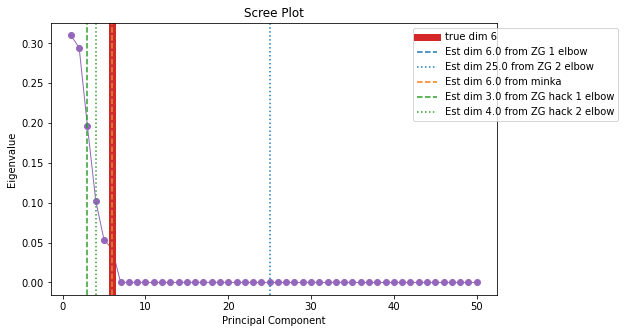

In [34]:
dims_minka = []
dims_ZG_1 = []
dims_ZG_2 = []
dims_ZG_h_1 = []
dims_ZG_h_2 = []
for i in range(100):
    A, out = perry_sim_dist(strong=True, sparse=False, noise='white', random_state=None)
    d = select_dimension(A, n_components = A.shape[1]-1)
    # due to the function not always returning two element list we only append the first 
    d_h = select_dimension(A)
    # due to the function not always returning two element list we only append the first
    dims_ZG_1.append(d[0][0])
    dims_ZG_h_1.append(d_h[0][0])
    if len(d[0]) > 1:
        dims_ZG_2.append(d[0][1])
    else:
        dims_ZG_2.append(0)
    if len(d_h[0]) > 1:
        dims_ZG_h_2.append(d_h[0][1])
    else:
        dims_ZG_h_2.append(0)
    dims_minka.append(minka(A))
dims_ZG_1 = np.asarray(dims_ZG_1)
dims_minka = np.asarray(dims_minka)
dims_ZG_2 = np.asarray(dims_ZG_2)
dims_ZG_h_1 = np.asarray(dims_ZG_h_1)
dims_ZG_h_2 = np.asarray(dims_ZG_h_2)
scree(A, out['rank'], dims_ZG_1, dims_ZG_2, dims_minka, dims_ZG_h_1, dims_ZG_h_2)